In [132]:
import soccerdata as sd
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm

In [133]:
df1 = pd.read_csv("FootballData_ENG-Premier League.csv")
df2 = pd.read_csv("FootballData_ITA-Serie A.csv")
df3 = pd.read_csv("FootballData_ESP-La Liga.csv")
df4 = pd.read_csv("FootballData_GER-Bundesliga.csv")
df5 = pd.read_csv("FootballData_FRA-Ligue 1.csv")
df = pd.concat([df1,df2,df3,df4,df5])
df


,Unnamed: 0.1,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Attendance,HHW,AHW,HO,AO,HBP,ABP,SYH,SYD,SYA
0,112,E0,01/01/1994,NaN,Aston Villa,Blackburn,0.0,1.0,A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,113,E0,01/01/1994,NaN,Everton,West Ham,0.0,1.0,A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,E0,01/01/1994,NaN,Ipswich,Liverpool,1.0,2.0,A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,115,E0,01/01/1994,NaN,Man United,Leeds,0.0,0.0,D,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,116,E0,01/01/1994,NaN,Newcastle,Man City,2.0,0.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10803,10794,F1,31/10/2021,14:00,Montpellier,Nantes,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10804,10795,F1,31/10/2021,14:00,Strasbourg,Lorient,4.0,0.0,H,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10805,10796,F1,31/10/2021,14:00,Troyes,Rennes,2.0,2.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10806,10797,F1,31/10/2021,16:00,Brest,Monaco,2.0,0.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df.select_dtypes(["object"])

,Div,Date,Time,HomeTeam,AwayTeam,FTR,HTR,Referee
0,E0,01/01/1994,NaN,Aston Villa,Blackburn,A,NaN,NaN
1,E0,01/01/1994,NaN,Everton,West Ham,A,NaN,NaN
2,E0,01/01/1994,NaN,Ipswich,Liverpool,A,NaN,NaN
3,E0,01/01/1994,NaN,Man United,Leeds,D,NaN,NaN
4,E0,01/01/1994,NaN,Newcastle,Man City,H,NaN,NaN
...,...,...,...,...,...,...,...,...
10803,F1,31/10/2021,14:00,Montpellier,Nantes,H,D,NaN
10804,F1,31/10/2021,14:00,Strasbourg,Lorient,H,H,NaN
10805,F1,31/10/2021,14:00,Troyes,Rennes,D,H,NaN
10806,F1,31/10/2021,16:00,Brest,Monaco,H,H,NaN


In [135]:
df = df.drop(["Unnamed: 0.1","Div","Time","Referee"], axis=1)

In [136]:
# Dropearemos todas las columnas que tienen menos del 50% de los datos
porcentaje_minimo = 0.5 * len(df)
df = df.dropna(axis=1, thresh=int(porcentaje_minimo))
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,IWA,WHH,WHD,WHA,VCH,VCD,VCA,LBH,LBD,LBA
0,01/01/1994,Aston Villa,Blackburn,0.0,1.0,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/01/1994,Everton,West Ham,0.0,1.0,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/01/1994,Ipswich,Liverpool,1.0,2.0,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/01/1994,Man United,Leeds,0.0,0.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/01/1994,Newcastle,Man City,2.0,0.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10803,31/10/2021,Montpellier,Nantes,2.0,0.0,H,0.0,0.0,D,19.0,...,3.00,2.30,3.4,2.90,2.30,3.40,3.00,NaN,NaN,NaN
10804,31/10/2021,Strasbourg,Lorient,4.0,0.0,H,3.0,0.0,H,15.0,...,3.80,1.90,3.4,3.90,1.95,3.40,4.00,NaN,NaN,NaN
10805,31/10/2021,Troyes,Rennes,2.0,2.0,D,2.0,1.0,H,14.0,...,2.00,3.75,3.4,1.95,3.90,3.40,1.95,NaN,NaN,NaN
10806,31/10/2021,Brest,Monaco,2.0,0.0,H,1.0,0.0,H,7.0,...,1.77,4.33,3.7,1.75,4.60,3.75,1.73,NaN,NaN,NaN


In [137]:
df_ceros = df.fillna(-1)

for columna in df_ceros.columns:
    if columna not in df.select_dtypes(["object"]).keys():
        nombre_columna_indicadora = columna + '_presente'
        df[nombre_columna_indicadora] = df_ceros[columna].apply(lambda x: 1 if x != -1 else 0)
df = df.fillna(0)

In [77]:
def encontrar_min_feature(row):
    max_value = row.min()
    max_features = row[row == max_value].index.tolist()  # Obtener todas las características con el valor máximo
    if len(max_features) == 1:
        return max_features[0]  # Si solo hay una característica con el valor máximo, retornar su nombre
    else:
        return 'D'  # Si hay un empate, retornar 'Draw'

# Crear una nueva columna con la característica que tiene el valor máximo, manejando empates
df["B365"] = df[['B365H', 'B365D', 'B365A']].apply(encontrar_min_feature, axis=1)
df["BW"] = df[['BWH', 'BWD', 'BWA']].apply(encontrar_min_feature, axis=1)
df["IW"] = df[['IWH', 'IWD', 'IWA']].apply(encontrar_min_feature, axis=1)
df["WH"] = df[['WHH', 'WHD', 'WHA']].apply(encontrar_min_feature, axis=1)
df["VC"] = df[['VCH', 'VCD', 'VCA']].apply(encontrar_min_feature, axis=1)
df["LB"] = df[['LBH', 'LBD', 'LBA']].apply(encontrar_min_feature, axis=1)

In [78]:
def comparacion_resultado(row):
    if row[0] == 0:
        return -1
    Resultado = row[1][-1]
    if Resultado == row[2]:
        return 1
    else:
        return 0
    

df["B365_correcto"] = df[["B365H_presente","B365","FTR"]].apply(comparacion_resultado, axis=1)
df["BW_correcto"] = df[["BWH_presente","BW","FTR"]].apply(comparacion_resultado, axis=1)
df["IW_correcto"] = df[["IWH_presente","IW","FTR"]].apply(comparacion_resultado, axis=1)
df["WH_correcto"] = df[["WHH_presente","WH","FTR"]].apply(comparacion_resultado, axis=1)
df["VC_correcto"] = df[["VCH_presente","VC","FTR"]].apply(comparacion_resultado, axis=1)
df["LB_correcto"] = df[["LBH_presente","LB","FTR"]].apply(comparacion_resultado, axis=1)

C:\Users\gfuen\AppData\Local\Temp\ipykernel_11256\2159620430.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] == 0:
C:\Users\gfuen\AppData\Local\Temp\ipykernel_11256\2159620430.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Resultado = row[1][-1]
C:\Users\gfuen\AppData\Local\Temp\ipykernel_11256\2159620430.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if Resultado == row[2]:
C:\Users\gfuen\AppData\Local\Temp\

In [79]:
# Estadísticas
B365 = sum(df["B365_correcto"]==1) / sum(df["B365_correcto"]>=0)
BW = sum(df["BW_correcto"]==1) / sum(df["BW_correcto"]>=0)
IW = sum(df["IW_correcto"]==1) / sum(df["IW_correcto"]>=0)
WH = sum(df["WH_correcto"]==1) / sum(df["WH_correcto"]>=0)
VC = sum(df["VC_correcto"]==1) / sum(df["VC_correcto"]>=0)
LB = sum(df["LB_correcto"]==1) / sum(df["LB_correcto"]>=0)

print(f"B365 predichos :{B365}")
print(f"BW predichos :{BW}")
print(f"IW predichos :{IW}")
print(f"WH predichos :{WH}")
print(f"VC predichos :{VC}")
print(f"LB predichos :{LB}")

B365 predichos :0.5294209417821576
BW predichos :0.5294564056439373
IW predichos :0.5252283022067195
WH predichos :0.5281647339119442
VC predichos :0.5323482663213045
LB predichos :0.524517280545189


In [130]:
df = df.drop(['B365_correcto', 'BW_correcto', 'IW_correcto', 'WH_correcto', 'VC_correcto', 'LB_correcto',
              "B365","BW","IW","WH","VC","LB"],axis = 1)

KeyError: "['B365_correcto', 'BW_correcto', 'IW_correcto', 'WH_correcto', 'VC_correcto', 'LB_correcto', 'B365', 'BW', 'IW', 'WH', 'VC', 'LB'] not found in axis"

In [138]:
X = df.drop(["Date","FTR"], axis=1)
X = pd.get_dummies(X, columns=['HTR',"HomeTeam","AwayTeam"], dtype=int)

y = pd.get_dummies(df['FTR'], dtype=int)
df = df.drop(["FTR"], axis=1)

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [140]:
X_train

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,...,AwayTeam_Wattenscheid,AwayTeam_Werder Bremen,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wimbledon,AwayTeam_Wolfsburg,AwayTeam_Wolves,AwayTeam_Xerez,AwayTeam_Zaragoza
10321,18.0,9.0,7.0,1.0,16.0,13.0,8.0,10.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
10375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9364,11.0,9.0,6.0,1.0,15.0,17.0,4.0,3.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
8598,20.0,16.0,9.0,3.0,12.0,18.0,4.0,10.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3844,10.0,9.0,8.0,1.0,7.0,4.0,7.0,6.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
y_train

,A,D,H
2763,1,0,0
6526,1,0,0
8675,1,0,0
6874,0,1,0
2933,0,1,0
...,...,...,...
3385,1,0,0
4981,0,0,1
671,0,0,1
2070,0,0,1


In [125]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


drop = 0.0
size_layer = 2 ^ 1
batch_size = 2 ^ 6
epoch = 10
model = Sequential([
    Dense(size_layer, activation='relu',
          input_shape=(X.shape[1],), use_bias=True,),
    Dense(y.shape[1], activation='softmax', use_bias=True,)
])
# # Compilamos el modelo
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.99, beta_2=0.9999)

hinge = tf.keras.losses.CategoricalHinge()
focal_cross = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=0.2, gamma=2, from_logits=False, label_smoothing=0.0)
cross = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0.0)

model.compile(loss=cross,
              optimizer=adam, metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/10
10849/10849 [==============================] - 8s 685us/step - loss: 0.4121 - categorical_accuracy: 0.8845 - val_loss: 0.1106 - val_categorical_accuracy: 1.0000
Epoch 2/10
10849/10849 [==============================] - 7s 681us/step - loss: 0.0587 - categorical_accuracy: 1.0000 - val_loss: 0.0298 - val_categorical_accuracy: 1.0000
Epoch 3/10
10849/10849 [==============================] - 7s 684us/step - loss: 0.0189 - categorical_accuracy: 1.0000 - val_loss: 0.0117 - val_categorical_accuracy: 1.0000
Epoch 4/10
10770/10849 [============================>.] - ETA: 0s - loss: 0.0082 - categorical_accuracy: 1.0000

KeyboardInterrupt: 

1357/1357 [==============================] - 1s 447us/step


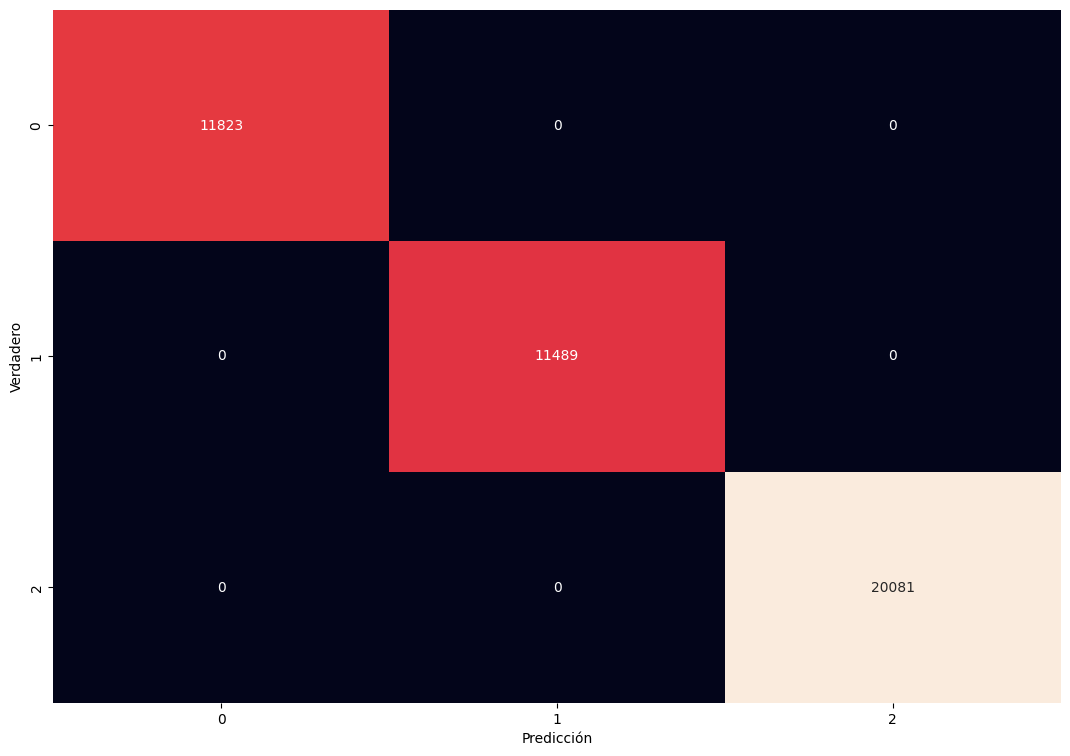

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


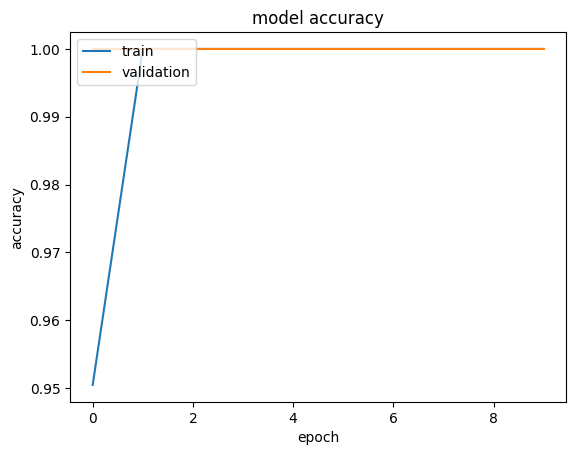

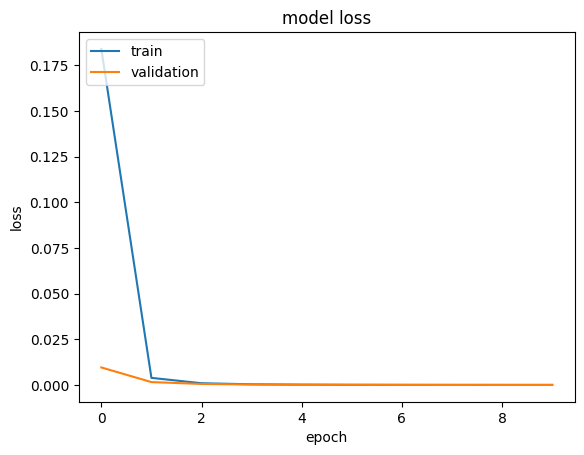

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from copy import deepcopy

y_prob = model.predict(X_train)
y_test_metrics = np.argmax(y_train, axis=1)
y_pred = np.argmax(y_prob, axis=1)

y_pred_copy = deepcopy(y_pred)
y_test_metrics_copy = deepcopy(y_test_metrics)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
plt.figure(figsize=(13, 9))

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')